In [1]:
# Importing packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

### Data Understanding

In [2]:
tackle = pd.read_excel('player_cleaned_data.xlsx')

In [3]:
tackle.head()

,match_id,Team,id,name,short_name,red_card,yellow_card,green_card,played,captain,...,winning_team,toss_winner,venue,toss_choice,toss_direction,winning_score,loosing_score,Year,Month,Season
0,1,JAI,15,Sanjay Shrestha,Sanjay Shrestha,False,False,False,True,False,...,U Mumba,U Mumba,"DOME@NSCI SVP Stadium, Mumbai",Choice of court,Right,45,31,2014,7,Season 1
1,1,JAI,96,Rohit Rana,Rohit Rana,False,False,False,True,False,...,U Mumba,U Mumba,"DOME@NSCI SVP Stadium, Mumbai",Choice of court,Right,45,31,2014,7,Season 1
2,1,JAI,72,Navneet Gautam,Navneet Gautam,False,False,False,True,True,...,U Mumba,U Mumba,"DOME@NSCI SVP Stadium, Mumbai",Choice of court,Right,45,31,2014,7,Season 1
3,1,JAI,52,Jasvir Singh,Jasvir Singh,False,False,False,True,False,...,U Mumba,U Mumba,"DOME@NSCI SVP Stadium, Mumbai",Choice of court,Right,45,31,2014,7,Season 1
4,1,JAI,22,Wei Yang,Wei Yang,False,False,False,True,False,...,U Mumba,U Mumba,"DOME@NSCI SVP Stadium, Mumbai",Choice of court,Right,45,31,2014,7,Season 1


In [4]:
#tackle.drop(['match_id','date','temp'],axis=1,inplace=True)
tackle.drop(['match_id','date'],axis=1,inplace=True)

In [5]:
for each in ['red_card','yellow_card','green_card','played','captain','on_court','starter','top_raider',
            'top_defender','toss_direction','toss_choice']:
    
    freq = tackle[each].mode()[0]
    tackle[each] = tackle[each].apply(lambda x : 1 if x == freq else 0)

In [6]:
tackle['start_time'].unique()

array(['20:00', '21:00', '21:15', '19:30', '20:30'], dtype=object)

In [7]:
tackle['raider_sucess_%'] = tackle['raids_successful']/ tackle['raids_total'] * 100

In [8]:
tackle.drop(['raids_successful','raids_total'],axis=1,inplace=True)

In [9]:
tackle['tackle_sucess_%'] = tackle['tackles_successful']/ tackle['tackles_total'] * 100

In [10]:
tackle.drop(['tackles_successful','tackles_total'],axis=1,inplace=True)

In [11]:
tackle['raider_sucess_%'].fillna(0,inplace=True)
tackle['tackle_sucess_%'].fillna(0,inplace=True)

In [12]:
tackle[['start_time','raider_sucess_%']].groupby('start_time').describe(percentiles=[.25,.5,.75,.9,.95,.99])

raider_sucess_%                                                  \
                     count       mean        std  min  25%  50%        75%   
start_time                                                                   
19:30               1459.0  11.131878  20.164083  0.0  0.0  0.0  20.000000   
20:00               7077.0  11.947603  21.308876  0.0  0.0  0.0  20.000000   
20:30               1222.0  11.604431  21.101383  0.0  0.0  0.0  20.000000   
21:00               5678.0  12.195719  21.648886  0.0  0.0  0.0  21.428571   
21:15                 24.0   8.469043  16.553768  0.0  0.0  0.0   3.125000   

                                                          
                  90%        95%         99%         max  
start_time                                                
19:30       42.857143  50.217391   77.777778  100.000000  
20:00       45.454545  55.555556  100.000000  100.000000  
20:30       45.454545  54.545455  100.000000  100.000000  
21:00       45.454545  54.545455  100.000000  100.000000  
21:15       37.000000  45.230769   50.948718   52.380952

In [13]:
def group_time(x):
    if x == '19:30':
        return 'Early'
    elif x=='21:15':
        return 'Late'
    else:
        return 'Ususal'

tackle['start_time'] = tackle['start_time'].apply(lambda x : group_time(x))

In [14]:
tackle.index = range(0,len(tackle))

In [15]:
for i in range(0,len(tackle)):
    if tackle.loc[i,'Team'] in tackle.loc[i,'winning_team'].upper():
        tackle.loc[i,'winning_team'] = 1
    else:
        tackle.loc[i,'winning_team'] = 0

In [16]:
for i in range(0,len(tackle)):
    if tackle.loc[i,'Team'] in tackle.loc[i,'toss_winner'].upper():
        tackle.loc[i,'toss_winner'] = 1
    else:
        tackle.loc[i,'toss_winner'] = 0

In [17]:
tackle.shape

(15460, 40)

In [18]:
tackle.shape

(15460, 40)

In [19]:
player_id = tackle['id']
player_name = tackle['name']
player_short_name = tackle['short_name']

In [20]:
tackle.drop(['Team','id','name','short_name'],axis=1,inplace=True)

In [21]:
tackle['Season'] = tackle['Season'].astype('category')
tackle['venue'] = tackle['venue'].astype('category')

### Data Preparation for model

In [22]:
cat = pd.get_dummies(tackle.select_dtypes(include='object'))

In [23]:
tackle_model = pd.concat([cat,tackle.select_dtypes(exclude='object')],axis=1)

In [24]:
tackle_model.shape

(15460, 38)

In [25]:
tackle_train = tackle_model[tackle_model['Season'] != 'Season 7']

In [26]:
tackle_train.shape

(12731, 38)

In [27]:
tackle_test = tackle_model[tackle_model['Season'] == 'Season 7']

In [28]:
tackle_test.shape

(2729, 38)

In [29]:
X_train = tackle_train.drop(['tackle_sucess_%','Season','venue','tackle_points_total','Player_points_total','raider_points_total'],axis=1)
y_train = tackle_train['tackle_sucess_%']

In [30]:
X_test = tackle_test.drop(['tackle_sucess_%','Season','venue','tackle_points_total','Player_points_total','raider_points_total'],axis=1)
y_test = tackle_test['tackle_sucess_%']

In [31]:
# storing column names in cols, since column names are (annoyingly) lost after 
# scaling (the df is converted to a numpy array)

scaler = StandardScaler()

X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])

In [32]:
X_test[X_train.columns] = scaler.transform(X_test[X_train.columns])

### Model

In [33]:
params = {'alpha': [0.0001,0.001,0.01,0.02,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,5,10,50,100,200,500]}

In [34]:
lasso = Lasso()

# cross validation
folds=5
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1432644.873717249, tolerance: 864.5399365918324
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1415239.1219090712, tolerance: 859.5733949549262
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1426236.1993215866, tolerance: 866.5309371615939
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective d

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.02, 0.05, 0.1, 0.2,
                                   0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 5, 10,
                                   50, 100, 200, 500]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [35]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.214645,0.081832,0.001197,0.000399,0.0001,{'alpha': 0.0001},-12.213413,-10.330510,-10.516013,-10.017940,...,-10.628159,0.813326,11,-9.711439,-10.325002,-10.337673,-10.323738,-10.233541,-10.186279,0.240319
1,0.184913,0.075751,0.000997,0.000631,0.001,{'alpha': 0.001},-12.210712,-10.329953,-10.515228,-10.017661,...,-10.627357,0.812334,10,-9.711066,-10.324874,-10.337647,-10.323638,-10.233531,-10.186151,0.240436
2,0.058644,0.013969,0.001795,0.000746,0.01,{'alpha': 0.01},-12.179666,-10.326349,-10.507787,-10.014416,...,-10.618374,0.801125,8,-9.708163,-10.323397,-10.336886,-10.322173,-10.233355,-10.184795,0.241143
3,0.026530,0.005224,0.001795,0.000399,0.02,{'alpha': 0.02},-12.146130,-10.323885,-10.497983,-10.009468,...,-10.607413,0.789810,7,-9.705492,-10.320666,-10.336156,-10.319257,-10.232507,-10.182816,0.241429
4,0.014562,0.001621,0.001396,0.000489,0.05,{'alpha': 0.05},-12.048163,-10.331171,-10.497117,-10.003481,...,-10.585156,0.754067,5,-9.703644,-10.320036,-10.335187,-10.314804,-10.234617,-10.181657,0.241557


In [36]:
cv_results[['param_alpha','mean_train_score','mean_test_score']]

,param_alpha,mean_train_score,mean_test_score
0,0.0001,-10.186279,-10.628159
1,0.001,-10.186151,-10.627357
2,0.01,-10.184795,-10.618374
3,0.02,-10.182816,-10.607413
4,0.05,-10.181657,-10.585156
5,0.1,-10.188115,-10.561628
6,0.2,-10.204181,-10.514830
7,0.3,-10.229736,-10.466410
8,0.4,-10.274398,-10.538684
9,0.5,-10.309071,-10.600305


In [37]:
model_cv.best_params_

{'alpha': 0.3}

In [38]:
alpha = 0.2

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [39]:
lasso.score(X_train,y_train)

0.6573349100636805

In [40]:
y_predict = lasso.predict(X_test)

In [41]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [42]:
print(r2_score(y_test,y_predict))
print(np.sqrt(mean_squared_error(y_test,y_predict)))

0.6967587583749233
16.00368481865428


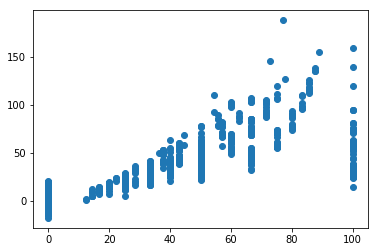

In [43]:
plt.scatter(y_test,y_predict)

In [44]:
features = np.abs(pd.Series(dict(zip(X_train.columns,lasso.coef_)))).sort_values(ascending=False)

In [45]:
features.head(10)

tackle_points_capture          25.092184
tackles_unsuccessful            7.381072
top_defender                    3.523652
starter                         3.490338
on_court                        1.832498
played                          1.178502
tackle_points_capture_bonus     0.965538
raids_Empty                     0.689495
Year                            0.600896
raids_unsuccessful.1            0.471324
dtype: float64

In [46]:
defender = pd.DataFrame(np.array([player_name.loc[tackle_test.index].values,y_predict]).T,columns=['Playername','Predicted sucessful tackle %'])

In [47]:
defender['Predicted sucessful tackle %'] = defender['Predicted sucessful tackle %'].astype('float')
defender = defender[['Playername','Predicted sucessful tackle %']].groupby('Playername').mean().sort_values(by='Predicted sucessful tackle %',ascending=False)

In [48]:
defender.head()

,Predicted sucessful tackle %
Playername,
Fazel Atrachali,59.276601
Vishal Bhardwaj,53.585833
Sandeep Dhull,52.393749
Nitesh Kumar,51.528872
Baldev Singh,50.638052
